In [1]:
!pip install pandas matplotlib seaborn plotly  fredapi
!pip install interpret scikit-learn
!pip install xgboost
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from interpret.glassbox import ExplainableBoostingRegressor
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
fred = Fred(api_key='e956a3dbccd7d4f90be734f8d55b1d07')
series_id = 'RSAFS'
data = fred.get_series(series_id)

In [5]:
df = data.reset_index()
df.columns = ['date', 'y']
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [6]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

In [7]:
df['lag_1'] = df['y'].shift(1)
df['lag_2'] = df['y'].shift(2)
df['lag_3'] = df['y'].shift(3)

In [8]:
df.dropna(inplace=True)

In [9]:
features = ['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']
X = df[features]
y = df['y']

In [10]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [11]:
ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor()

In [12]:
y_pred = ebm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [13]:
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 119252.43610647871
RMSE: 143434.4438288879


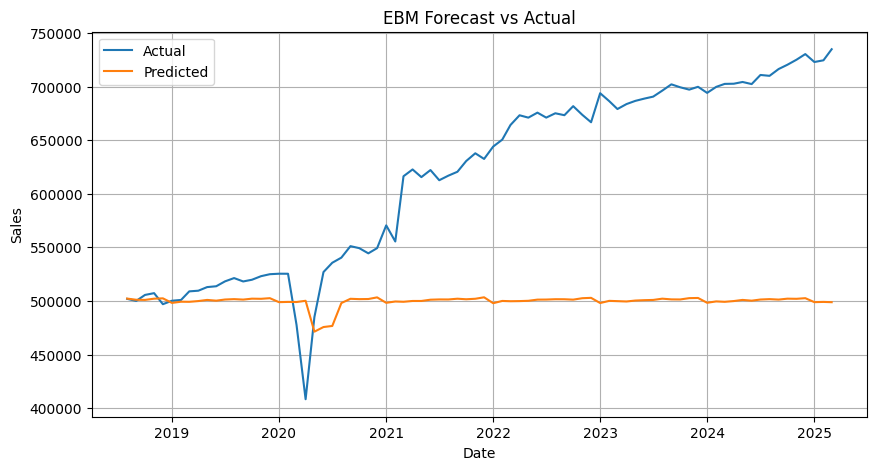

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'].iloc[train_size:], y_test.values, label='Actual')
plt.plot(df['date'].iloc[train_size:], y_pred, label='Predicted')
plt.legend()
plt.title('EBM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

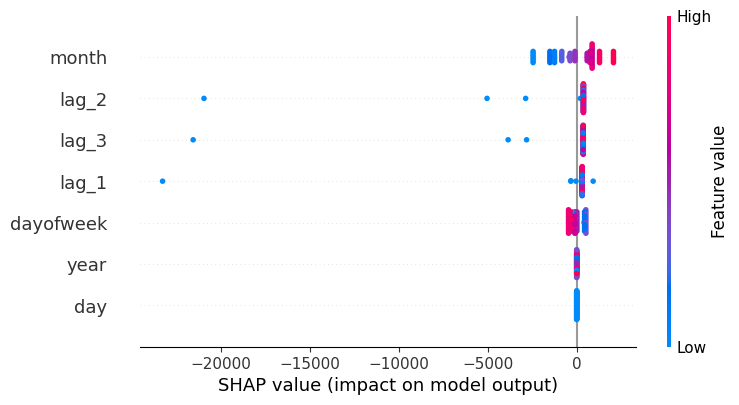

In [15]:
explainer = shap.Explainer(ebm.predict, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)